In [1]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

train_loss = []
validation_loss = []
for epoch in tqdm(range(25)):
    this_check = torch.load(f'Ali_GIT_checkpoints/Ali_GIT_epoch_{epoch}.tar')
    train_loss.append(this_check['loss_train'].item())
    validation_loss.append(this_check['loss_validation'].item())

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:46<00:00,  6.64s/it]


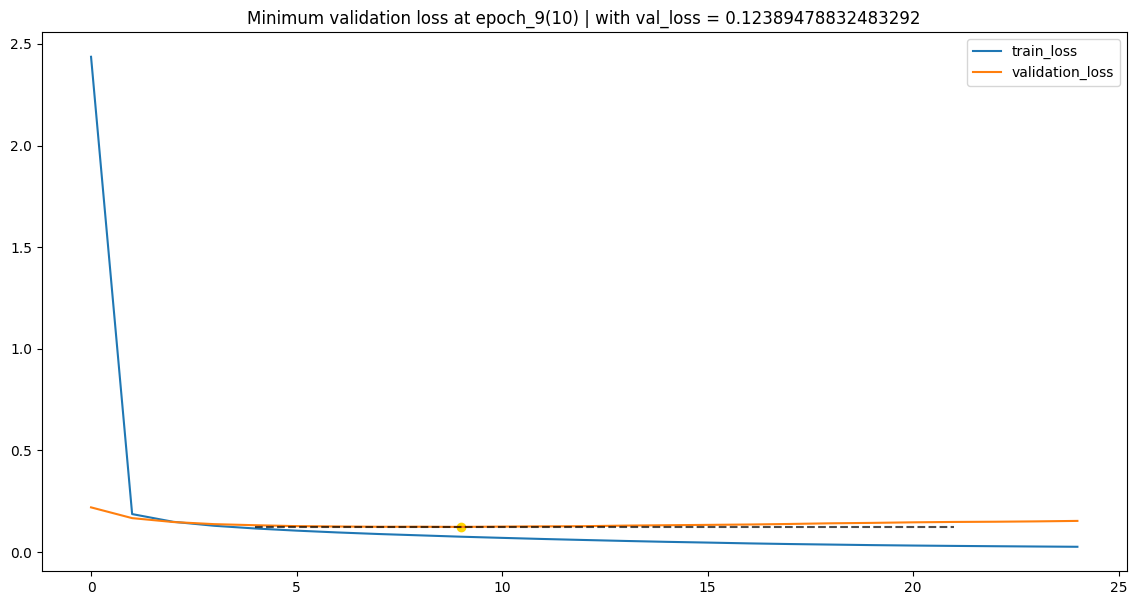

In [6]:
import numpy as np
plt.figure(figsize = (14,7))
plt.plot(range(25), train_loss, label = "train_loss")
plt.plot(range(25), validation_loss, label = "validation_loss")
plt.title(f"Minimum validation loss at epoch_{np.argmin(validation_loss)}({np.argmin(validation_loss)+1})"
+ f" | with val_loss = {validation_loss[np.argmin(validation_loss)]}")
plt.scatter(np.argmin(validation_loss), validation_loss[np.argmin(validation_loss)], c = 'gold')
plt.plot([np.argmin(validation_loss) - 5, np.argmin(validation_loss)+12],[validation_loss[np.argmin(validation_loss)],
                                                                        validation_loss[np.argmin(validation_loss)]],
         alpha = 0.7, c = 'k', linestyle = "--")
plt.legend()
plt.show()

In [7]:
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor

git_model = AutoModelForCausalLM.from_pretrained("microsoft/git-large").to("cuda")
processor = AutoProcessor.from_pretrained("microsoft/git-large")

In [10]:
best_check = torch.load('Ali_GIT_checkpoints/Ali_GIT_epoch_9.tar')
git_model.load_state_dict(best_check['model_state_dict'])

<All keys matched successfully>

In [11]:
from glob import glob
import re
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

image_path = "data/images/images_normalized/"
# Read in the projections data
projections = pd.read_csv('data/indiana_projections.csv')

# Read in the reports data
reports = pd.read_csv('data/indiana_reports.csv')

# Define the path to the images folder
images_folder = image_path

# Merge the projections and reports data on the UID column
reports = pd.merge(projections, reports, on='uid')

reports = reports[['uid', 'filename', 'projection', 'findings']]
reports.dropna(subset = ['findings'], inplace = True)

In [12]:
reports = reports[reports.projection == "Frontal"].drop_duplicates(subset = 'uid')
reports.reset_index(drop = True, inplace = True)
reports

uid                   filename projection  \
0        1     1_IM-0001-4001.dcm.png    Frontal   
1        2     2_IM-0652-1001.dcm.png    Frontal   
2        4     4_IM-2050-1001.dcm.png    Frontal   
3        5  5_IM-2117-1003002.dcm.png    Frontal   
4        6     6_IM-2192-1001.dcm.png    Frontal   
...    ...                        ...        ...   
3194  3993  3993_IM-2044-1001.dcm.png    Frontal   
3195  3994  3994_IM-2045-2001.dcm.png    Frontal   
3196  3995  3995_IM-2046-1001.dcm.png    Frontal   
3197  3996  3996_IM-2047-1001.dcm.png    Frontal   
3198  3997  3997_IM-2048-1001.dcm.png    Frontal   

                                               findings  
0     The cardiac silhouette and mediastinum size ar...  
1     Borderline cardiomegaly. Midline sternotomy XX...  
2     There are diffuse bilateral interstitial and a...  
3     The cardiomediastinal silhouette and pulmonary...  
4     Heart size and mediastinal contour are within ...  
...                                                 ...  
3194  The heart is mildly enlarged. Left hemidiaphra...  
3195  Similar mild cardiomegaly. Of the pulmonary va...  
3196  The cardiomediastinal silhouette and pulmonary...  
3197  The lungs are clear. Heart size is normal. No ...  
3198  Heart size within normal limits. Small, nodula...  

[3199 rows x 4 columns]

In [13]:
class TextPreprocessing:
    
    def __lowercase(self, text):
        '''Converts to lowercase'''
        new_text = []
        for line in text:
            new_text.append(line.lower())
        
        clear_output(wait=True)
        print("1. lowercase finished successfully!")
        return new_text

    def __decontractions(self, text):
        '''Performs decontractions in the doc'''
        new_text = []
        for phrase in text:
            phrase = re.sub(r"won't", "will not", phrase)
            phrase = re.sub(r"can\'t", "can not", phrase)
            phrase = re.sub(r"couldn\'t", "could not", phrase)
            phrase = re.sub(r"shouldn\'t", "should not", phrase)
            phrase = re.sub(r"wouldn\'t", "would not", phrase)
            # general
            phrase = re.sub(r"n\'t", " not", phrase)
            phrase = re.sub(r"\'re", " are", phrase)
            phrase = re.sub(r"\'s", " is", phrase)
            phrase = re.sub(r"\'d", " would", phrase)
            phrase = re.sub(r"\'ll", " will", phrase)
            phrase = re.sub(r"\'t", " not", phrase)
            phrase = re.sub(r"\'ve", " have", phrase)
            phrase = re.sub(r"\'m", " am", phrase)
            phrase = re.sub(r"\*+", "abuse", phrase)
            new_text.append(phrase)
            
        clear_output(wait=True)
        print("2. decontractions finished successfully!")
        return new_text

    def __rem_punctuations(self, text):
        '''Removes punctuations'''
        punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*~''' # full stop is not removed
        new_text = []
        for line in text:
            for char in line:
                if char in punctuations: 
                    line = line.replace(char, "")
            new_text.append(' '.join(e for e in line.split()))
        
        clear_output(wait=True)
        print("3. remove punctuations finished successfully!")
        return new_text

    def __rem_numbers(self, text):
        '''Removes numbers and irrelevant text like xxxx*'''
        new_text = []
        for line in text:
            temp = re.sub(r'x*','',line)
            new_text.append(re.sub(r'\d','',temp))
            
        clear_output(wait=True)
        print("4. remove numbers finished successfully!")
        return new_text

    def __words_filter(self, text):
        '''Removes words less than 2 characters except no and ct'''
        new_text = []
        for line in text:
            temp = line.split()
            temp2 = []
            for word in temp:
                if  len(word) <=2 and word != 'no' and word != 'ct':
                    continue
                else:
                    temp2.append(word)
            new_text.append(' '.join(e for e in temp2))
            
        clear_output(wait=True)
        print("5. words filter finished successfully!")
        return new_text

    def __multiple_fullstops(self, text):
        ''' Removes multiple full stops from the text'''
        new_text = []
        for line in text:
            new_text.append(re.sub(r'\.\.+', '.', line))
            
        clear_output(wait=True)
        print("6. multiple fullstop finished successfully!")
        return new_text

    def __fullstops(self, text):
        new_text = []
        for line in text:
            new_text.append(re.sub('\.', ' .', line))
            
        clear_output(wait=True)
        print("7. fullstop finished successfully!")
        return new_text

    def __multiple_spaces(self, text):
        new_text = []
        for line in text:
            new_text.append(' '.join(e for e in line.split()))
            
        clear_output(wait=True)
        print("8. multiple spaces finished successfully!")
        return new_text

    def __separting_startg_words(self, text):
        new_text = []
        for line in text:
            temp = []
            words = line.split()
            for i in words:
                if i.startswith('.') == False:
                    temp.append(i)
                else:
                    w = i.replace('.','. ')
                    temp.append(w)
            new_text.append(' '.join(e for e in temp))
            
        clear_output(wait=True)
        print("9. separting start words finished successfully!")
        return new_text

    def __rem_apostrophes(self, text):
        new_text = []
        for line in text:
            new_text.append(re.sub("'",'',line))
            
        clear_output(wait=True)
        print("10. remove apostrophes words finished successfully!")
        return new_text

    def text_preprocessing(self, text):
        '''Combines all the preprocess functions'''
        new_text = self.__lowercase(text)
        new_text = self.__decontractions(new_text)
        new_text = self.__rem_punctuations(new_text)
        new_text = self.__rem_numbers(new_text)
        new_text = self.__words_filter(new_text)
        new_text = self.__multiple_fullstops(new_text)
        new_text = self.__fullstops(new_text)
        new_text = self.__multiple_spaces(new_text)
        new_text = self.__separting_startg_words(new_text)
        new_text = self.__rem_apostrophes(new_text)
        return new_text

In [14]:
text_preprocessing = TextPreprocessing()
reports['findings_preprocess'] = text_preprocessing.text_preprocessing(reports['findings'])

10. remove apostrophes words finished successfully!


In [15]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(reports, test_size = 0.1, random_state = 1)
train_df, val_df = train_test_split(train_df, test_size = test_df.shape[0], random_state = 1)

print("train_df shape =", train_df.shape)
print("val_df shape =", val_df.shape)
print("test_df shape =", test_df.shape)

train_df shape = (2559, 5)
val_df shape = (320, 5)
test_df shape = (320, 5)


In [17]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
from tqdm.autonotebook import tqdm
from IPython.display import display
from PIL import Image

predicted_caption_list = []
real_caption_list = []
for index in tqdm(range(test_df.shape[0])):
    item = test_df.iloc[index]
    filename = item['filename']
    real_caption = item['findings_preprocess']
    
    img  = Image.open('data/images/images_normalized/' +
                      filename).convert('RGB')

    inputs = processor(images=img, return_tensors="pt").to("cuda")
    pixel_values = inputs.pixel_values
    

    generated_ids = git_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    
    predicted_caption_list.append(generated_caption)
    real_caption_list.append(real_caption)

  0%|          | 0/320 [00:00<?, ?it/s]

In [52]:
import pandas as pd

df_results = pd.DataFrame(columns = ['image_path', 'Real_caption', 'GIT_caption'])

df_results['image_path'] = test_df['filename']
df_results['Real_caption'] = real_caption_list
df_results['GIT_caption'] = predicted_caption_list

In [69]:
def show_prediction(image_file_name):
    img  = Image.open('data/images/images_normalized/' +
                      image_file_name).convert('RGB')
    
    real = df_results[df_results.image_path == image_file_name]["Real_caption"].values[0]
    pred = df_results[df_results.image_path == image_file_name]["GIT_caption"].values[0]
    
    print("Real caption :", real)
    print("\n..........................\n")
    print("GIT caption :", pred)
    display(img)

Real caption : the lungs are grossly clear without focal pneumonic consolidation large effusion pneumothora .  heart size within normal limits . 

..........................

GIT caption : the heart normal size. the mediastinum unremarkable. the lungs are clear.


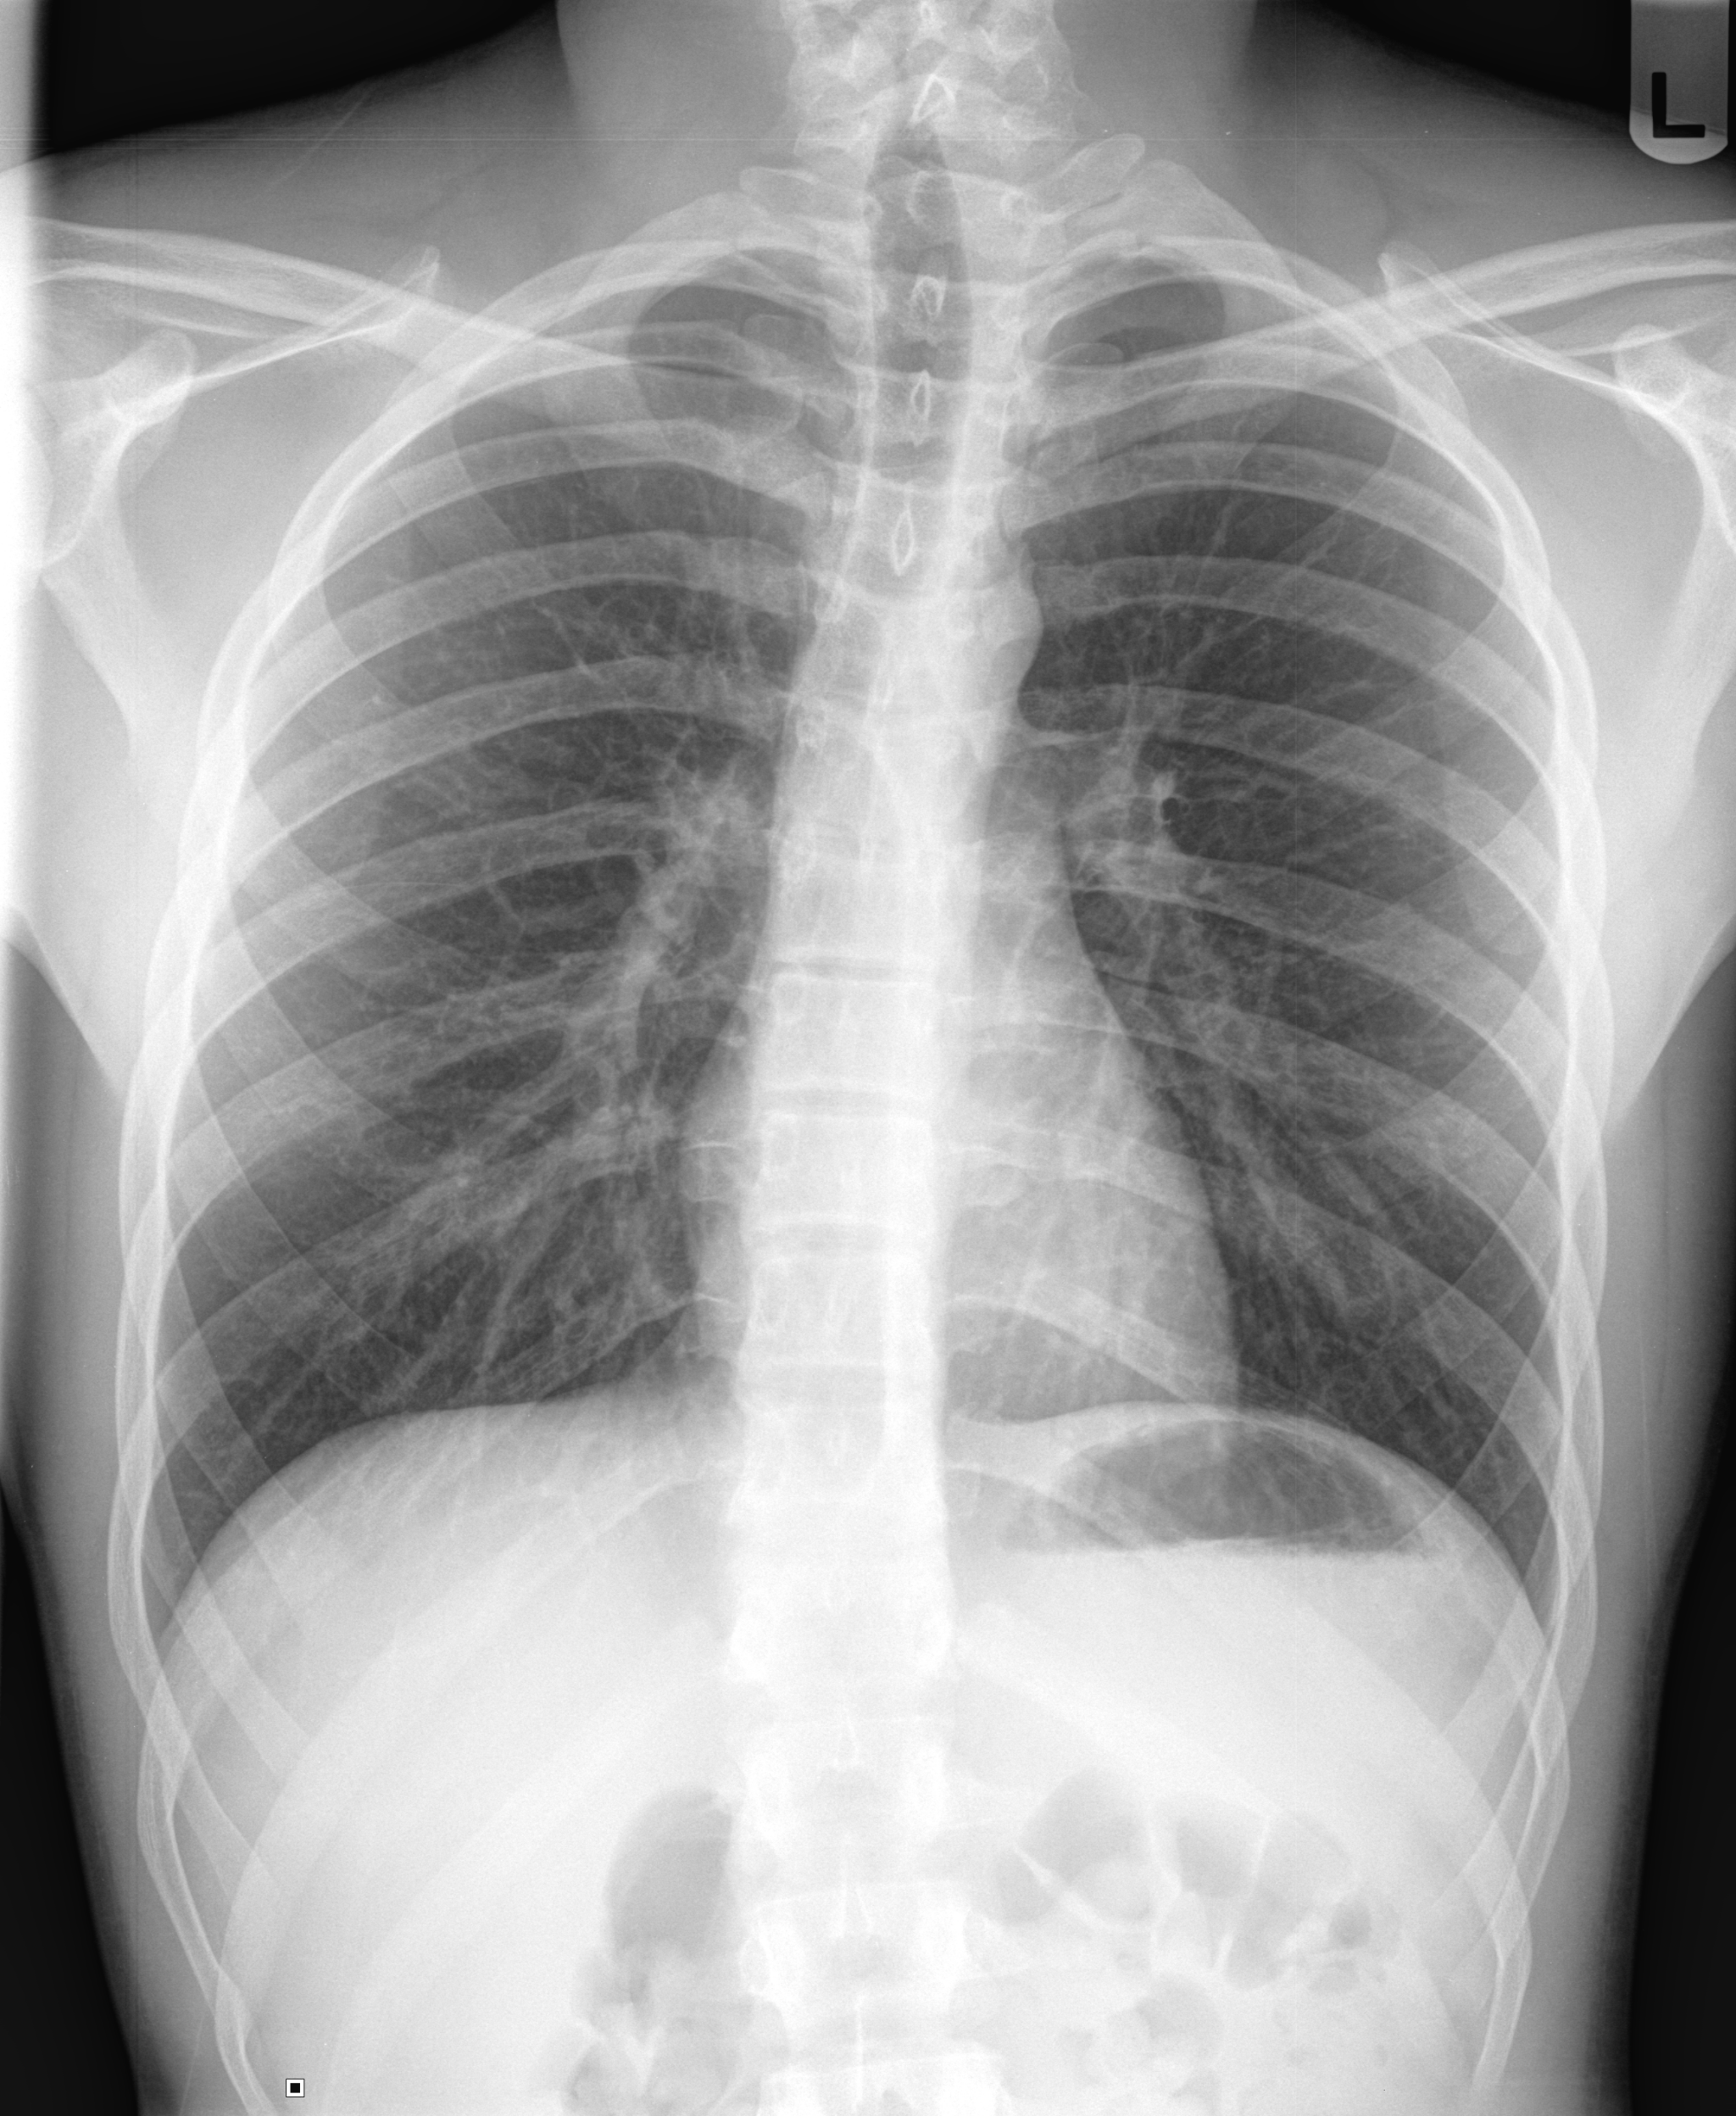

In [70]:
show_prediction("135_IM-0227-1001.dcm.png")

Real caption : the heart normal size and contour .  the lungs are clear without evidence infiltrate .  there no pneumothora effusion . 

..........................

GIT caption : the lungs are clear. there no pleural effusion pneumothora. the heart and mediastinum are normal. the skeletal structures and soft tissues are normal.


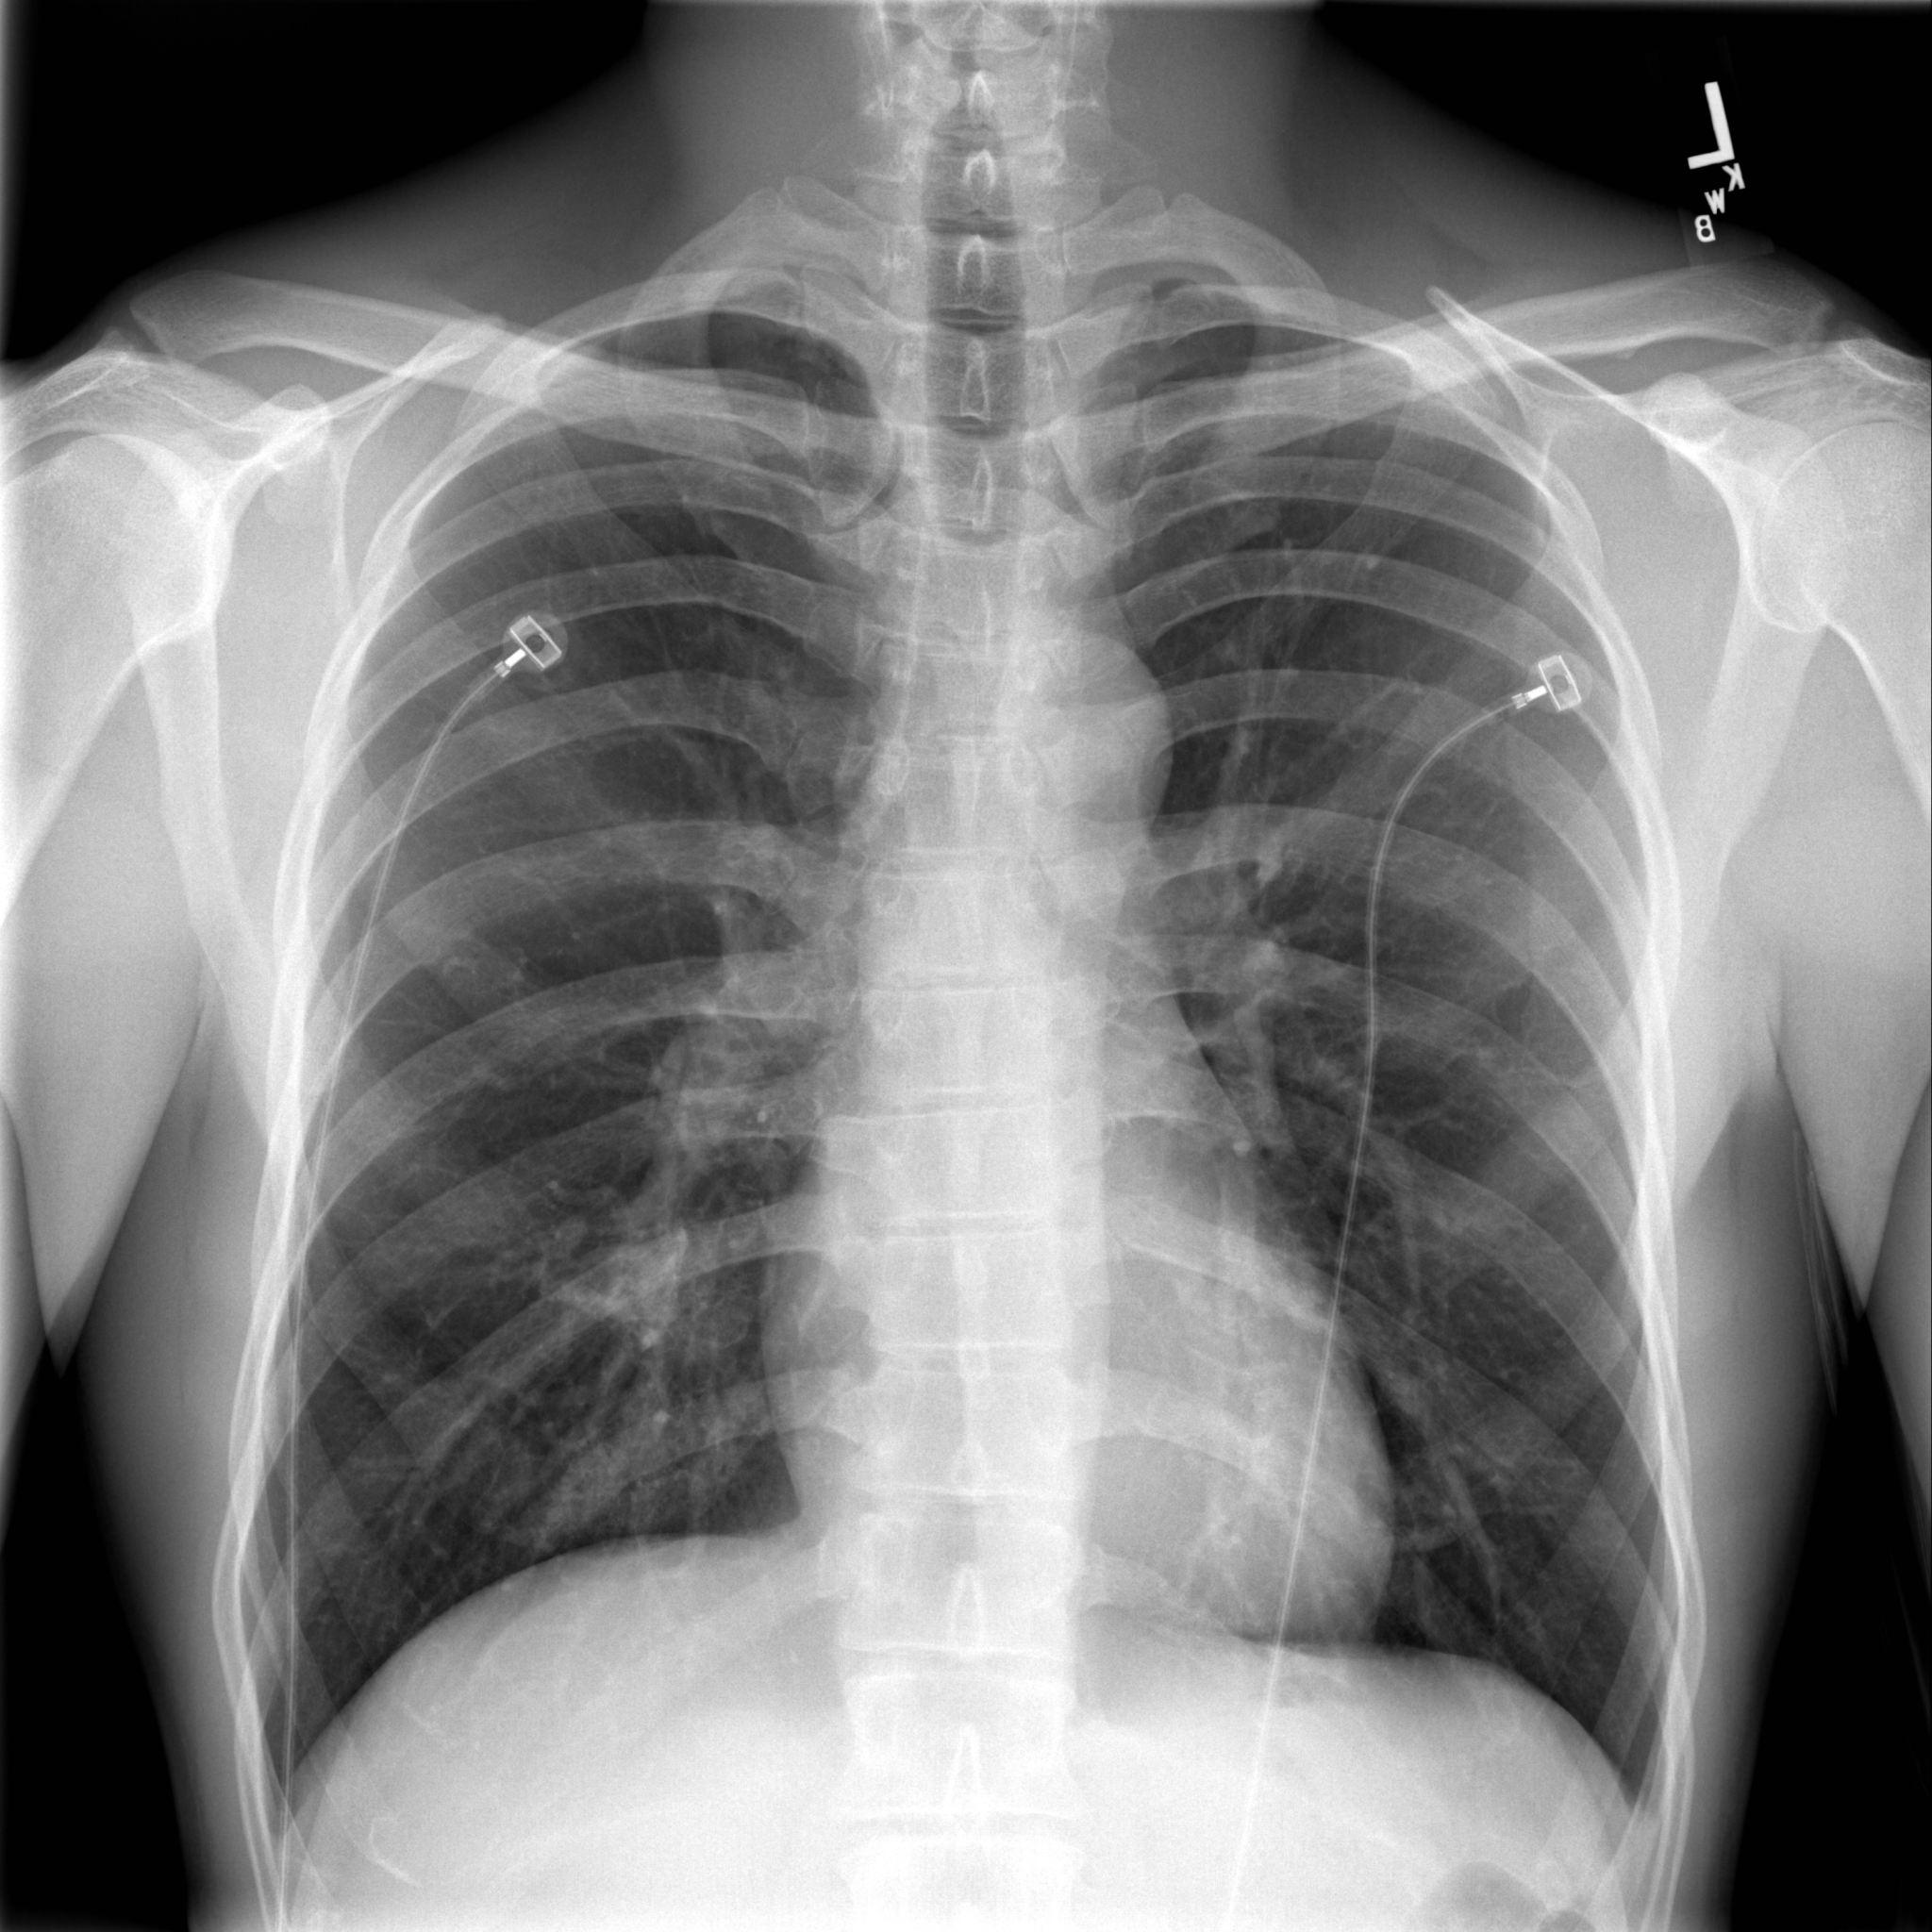

In [71]:
show_prediction("252_IM-1038-1001.dcm.png")